In [23]:
import scipy.special as sc
import pandas as pd
import numpy as np

# calculating Bayes factors for differential gene expression (BF_21)
def get_BF(N_1, n_1, N_2, n_2):

    return (sc.betaln( u_1 + n_1, u_2 + N_1 - n_1) + sc.betaln( u_1 + n_2, u_2 + N_2 - n_2) - sc.betaln( u_1 + n_1 + n_2, u_2 + N_1 - n_1 + N_2 - n_2)) / np.log(10) 

# ratio of expression 
# calculating log fold change
def get_FC(N_1, n_1, N_2, n_2):
    rate_1 = (u_1 + n_1) / (u_2 + N_1 - n_1)
    rate_2 = (u_1 + n_2) / (u_2 + N_2 - n_2)

    return np.log2(rate_2 / rate_1)

# calculating q (following Laplace's rule of succession)
# expected expression probability

def get_q(n, N):
    return (n+1)/(N+2)

# setting the priors to flat prios
u_1 = 1
u_2 = 1


# calculating Bayes factors (BF_IC) for consistency 

# input data is a data frame containing all read counts for all genes (rows) and replicates (colums)

def get_BF_IC(data):
    # this range is irrelevant if we want to do all replicates
    k = len(data.columns)

    evidence2 = np.full(len(data), 0)

    # iterating over j until k
    for col in data.columns[1:k]: 
        n_j = data[col]
        # print(n_j, 'n_j')
        N_j = sum(data[col])
        # print(N_j, 'N_j')
        evidence2 = evidence2 + sc.betaln(u_1 + n_j, u_2 + N_j - n_j)

    N = sum(data.iloc[:,1:k].sum(axis=0, numeric_only=True))
    n_i = data.iloc[:,1:k].sum(axis=1, numeric_only=True)

    # print(n_i, 'n_i')
    # print(N, 'N')

    evidence1 = sc.betaln( u_1 + n_i, u_2 + N - n_i)

    return (evidence2 - evidence1) / np.log(10) 


In [24]:
### Example test frame

# Read counts for 5 genes in two different experiments (cound be conditions, developmental timepoints, ...) with 3 replicates each.
    
in_data = pd.DataFrame({'genes': ['gene1', 'gene2', 'gene3', 'gene4', 'gene5'],
                        'exp 1 rep 1': [10, 100, 1000, 10000, 1000],
                        'exp 1 rep 2': [12, 120, 1200, 12000, 1000],
                        'exp 1 rep 3': [8, 80, 1100, 11000, 1000],
                        'exp 2 rep 1': [100, 100, 1200, 12000, 1000],
                        'exp 2 rep 2': [120, 120, 1300, 13000, 1000],
                        'exp 2 rep 3': [80, 80, 1400, 14000, 1000]
                        })

in_data

,genes,exp 1 rep 1,exp 1 rep 2,exp 1 rep 3,exp 2 rep 1,exp 2 rep 2,exp 2 rep 3
0,gene1,10,12,8,100,120,80
1,gene2,100,120,80,100,120,80
2,gene3,1000,1200,1100,1200,1300,1400
3,gene4,10000,12000,11000,12000,13000,14000
4,gene5,1000,1000,1000,1000,1000,1000


In [25]:
### Calculating Bayes factors (BF_21) and inferred fold change values

out_data = pd.DataFrame({'genes': in_data.genes})

# n_1 is the sum of all read counts in experiment 1 (replicates 1-3)
n_1 = in_data.iloc[:,1:4].sum(axis=1)

# n_2 is the sum of all read counts in experiment 2 (replicates 1-3)
n_2 = in_data.iloc[:,4:].sum(axis=1)

# N_1 and N_2 are the total number of reads in experiments 1 and 2, respectively
N_1 = in_data.iloc[:,1:4].sum(axis=1).sum()
N_2 = in_data.iloc[:,4:].sum(axis=1).sum()

out_data['BF'] = get_BF(N_1, n_1, N_2, n_2)
out_data['FC'] = get_FC(N_1, n_1, N_2, n_2)

out_data

,genes,BF,FC
0,gene1,43.703090,3.057036
1,gene2,-2.007143,-0.232257
2,gene3,-2.302165,0.011255
3,gene4,-0.975450,0.063145
4,gene5,6.581409,-0.247983


In [26]:
# Furthermore, you can calculate a Bayes factor for consistency from that (very limited!) data

# input data is a data frame containing all read counts for all genes (rows) and replicates (colums)
exp_1 = in_data.iloc[:,1:4]
exp_2 = in_data.iloc[:,4:]

display(exp_1)
display(exp_2)

out_data['BF_IC_1'] = get_BF_IC(exp_1)
out_data['BF_IC_2'] = get_BF_IC(exp_2)

out_data

,exp 1 rep 1,exp 1 rep 2,exp 1 rep 3
0,10,12,8
1,100,120,80
2,1000,1200,1100
3,10000,12000,11000
4,1000,1000,1000


,exp 2 rep 1,exp 2 rep 2,exp 2 rep 3
0,100,120,80
1,100,120,80
2,1200,1300,1400
3,12000,13000,14000
4,1000,1000,1000


,genes,BF,FC,BF_IC_1,BF_IC_2
0,gene1,43.703090,3.057036,-2.981373,-0.305491
1,gene2,-2.007143,-0.232257,-1.488666,-0.305491
2,gene3,-2.302165,0.011255,-2.075284,-2.091895
3,gene4,-0.975450,0.063145,-1.839520,-0.967662
4,gene5,6.581409,-0.247983,-1.294648,-1.701523


In [27]:
# get q values for all genes in all replicates for the q plots

exp_1_q = pd.DataFrame({})

for col in exp_1.columns:

    exp_1_q[col+'_q'] = (exp_1[col]+1) / (sum(exp_1[col])+2)

display(exp_1_q)

exp_2_q = pd.DataFrame({})

for col in exp_2.columns:

    exp_2_q[col+'_q'] = (exp_2[col]+1) / (sum(exp_2[col])+2)

display(exp_2_q)

,exp 1 rep 1_q,exp 1 rep 2_q,exp 1 rep 3_q
0,0.000908,0.000907,0.000682
1,0.008339,0.008441,0.006141
2,0.082645,0.083787,0.083472
3,0.825710,0.837240,0.834041
4,0.082645,0.069834,0.075891


,exp 2 rep 1_q,exp 2 rep 2_q,exp 2 rep 3_q
0,0.007013,0.007785,0.004891
1,0.007013,0.007785,0.004891
2,0.083391,0.083709,0.084591
3,0.833287,0.836508,0.845369
4,0.069504,0.064406,0.060440


In [28]:
# plotting expected expression probabilities q_i for genes i across replicates

import matplotlib.pyplot as plt

def q_plot(exp_1, exp_2):

    # printing q-plots
    for t in range(len(exp_1)):
        fig, ax = plt.subplots(dpi=300)

        # histogram Exp 1
        ax.hist(exp_1.iloc[t], 10, density=False, histtype='step', color='#332288',
                alpha=0.4, orientation='horizontal')

        # histogram Exp 2
        ax.hist(exp_2.iloc[t], 10, density=False, histtype='step', color='#DDCC77',
                alpha=0.4, orientation='horizontal')


        # scatter Exp 1
        ax.scatter(np.arange(1,len(exp_1.columns)+1), exp_1.iloc[t],
                
            c='#332288', s=30, 
            label='Experiment 1',
            alpha=0.9, edgecolors='none')
        
        # scatter Exp 2
        ax.scatter(np.arange(1,len(exp_2.columns)+1), exp_2.iloc[t],
                
            c='#DDCC77', s=30, 
            label='Experiment 2',
            alpha=0.9, edgecolors='none')
        
        ax.legend(loc='upper right')

        # Use tex in labels
        ax.set_xticks(np.arange(1,len(exp_1.columns)+1))
        ax.set_xticklabels('')

        # formatting y axis ticks
        plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)

        ax.set_xlabel('Replicates')
        ax.set_ylabel('q = (n+1) / (N+2)')

        plt.show()



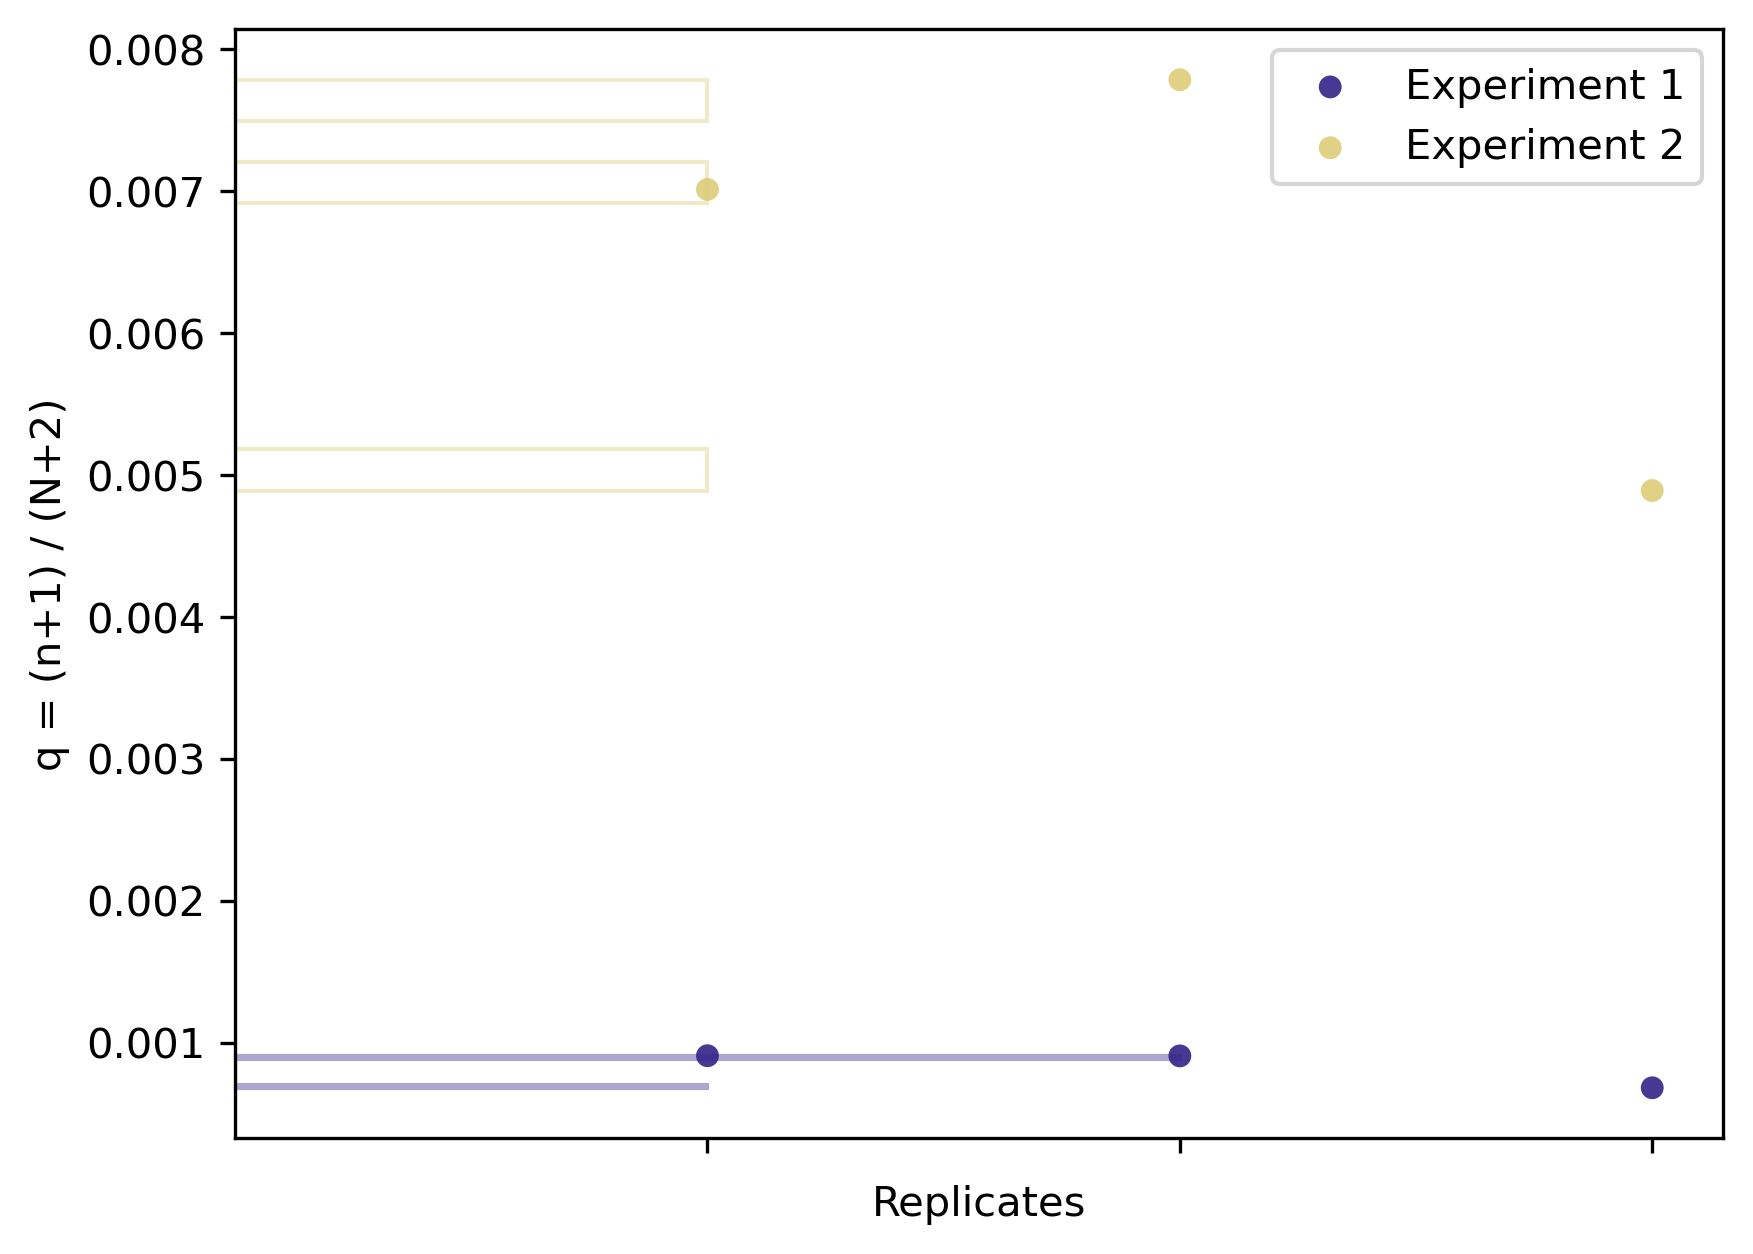

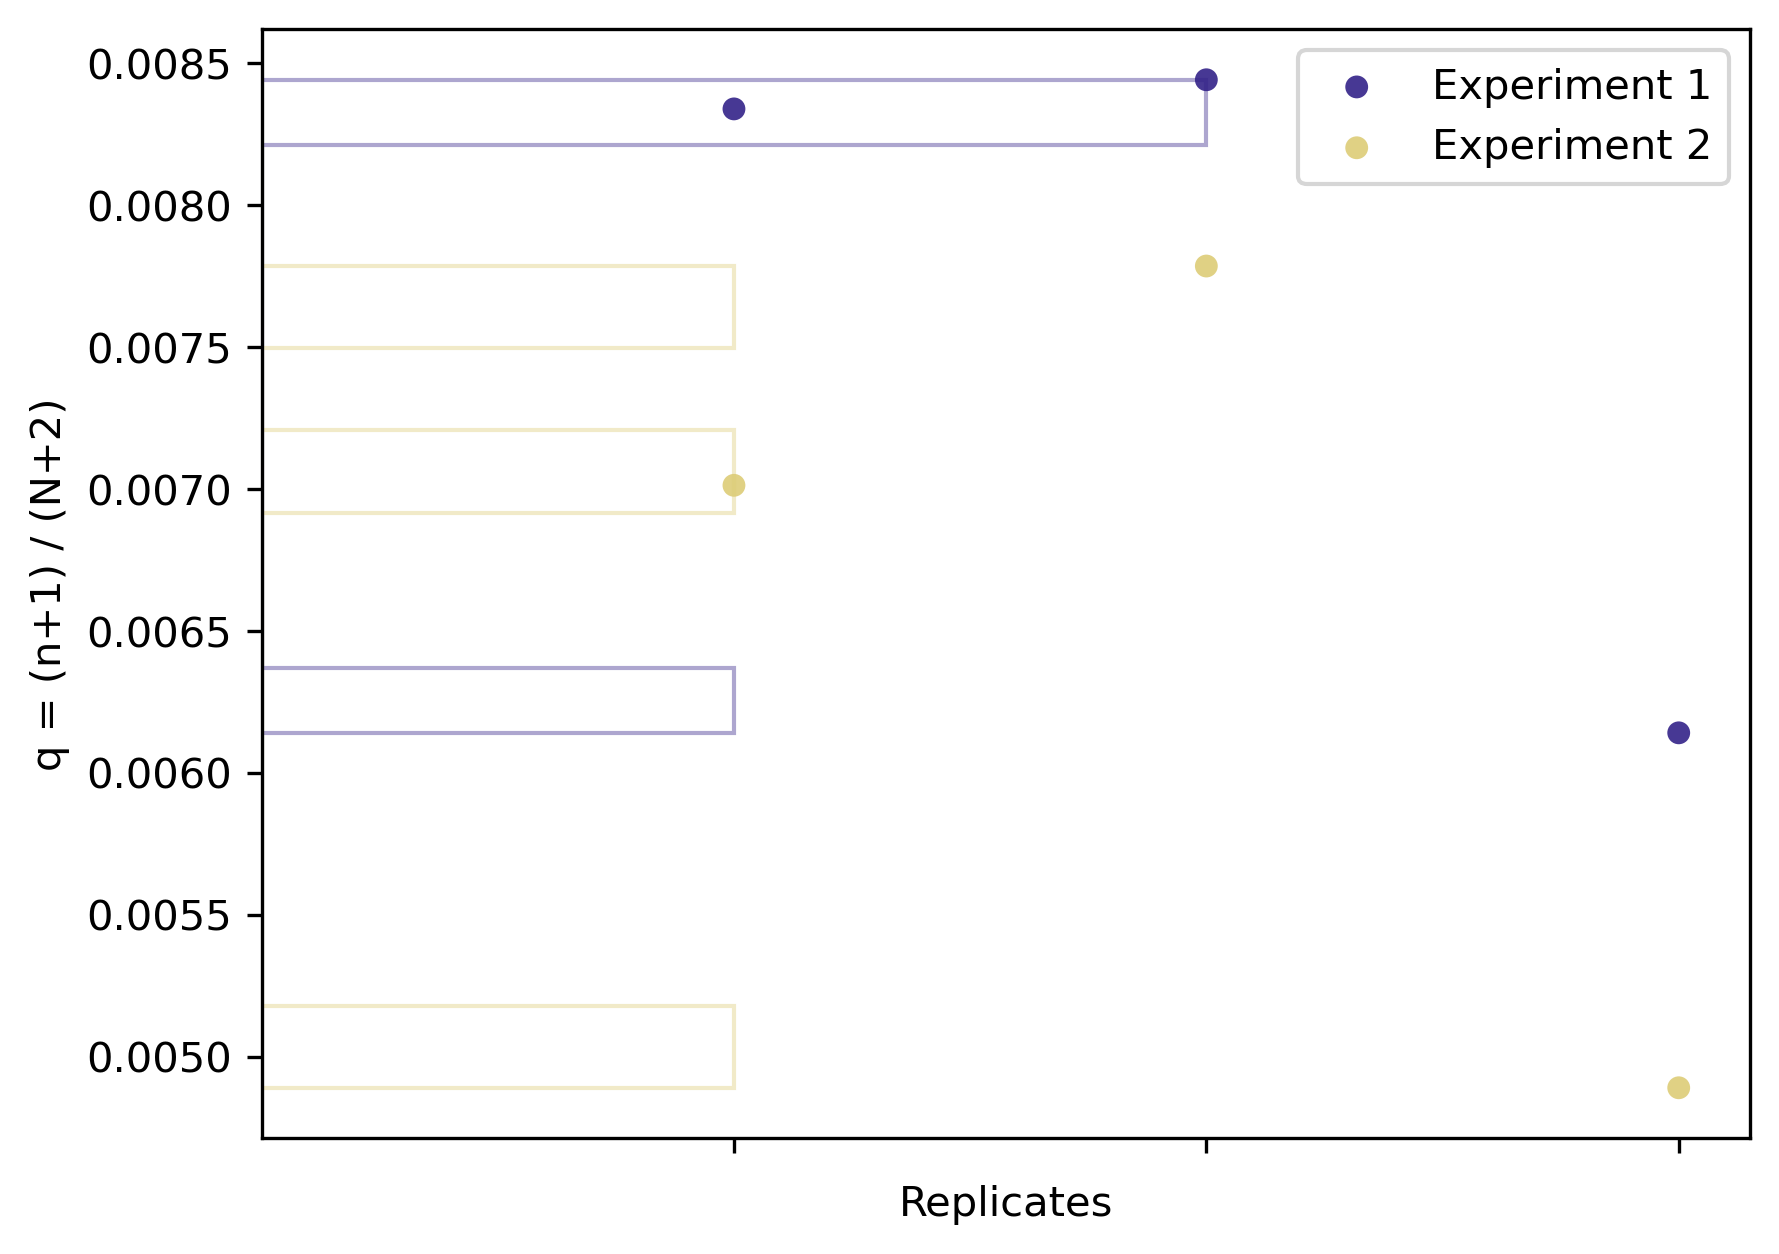

In [36]:
# input q value tables

q_plot(exp_1_q.iloc[:2,:], exp_2_q.iloc[:2,:])

# does not make a lot of sense or a good plot with 3 reps anyways 

In [30]:
# now let's do the same again with some real data
# importing yeast data

# we can use the yeast data set with all replicates (42 and 44)
# every column is one replicate and we have two data frames for the two conditions (in this case a WT and an Snf2-mutant)
WT_yeast = pd.read_csv('WT_yeast.csv', index_col=0)
Snf2_yeast = pd.read_csv('Snf2_yeast.csv', index_col=0)

display(WT_yeast)
display(Snf2_yeast)

,genes,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,15S_rRNA,2,12,31,8,21,11,2,3,7,...,0,49,9,4,11,12,1,22,12,4
1,21S_rRNA,20,76,101,99,128,74,36,32,57,...,10,274,49,30,72,58,21,159,107,70
2,HRA1,3,2,2,2,3,5,4,0,4,...,5,3,6,5,2,2,2,5,2,1
3,ICR1,75,123,107,157,98,245,119,120,119,...,85,177,137,118,113,81,142,94,187,106
4,LSR1,60,163,233,163,193,375,194,84,211,...,66,385,232,149,114,81,109,132,243,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7122,tY(GUA)M1,0,0,1,1,1,1,0,0,1,...,0,1,1,0,1,0,0,0,1,0
7123,tY(GUA)M2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7124,tY(GUA)O,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


,genes,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,15S_rRNA,4,2,5,5,46,5,4,2,40,...,7,15,6,1,85,8,34,3,6,3
1,21S_rRNA,31,18,23,44,356,35,33,13,148,...,64,79,67,13,576,52,234,23,44,24
2,HRA1,5,1,3,1,2,1,4,4,0,...,5,5,0,2,0,1,2,2,0,1
3,ICR1,205,196,211,252,127,275,160,190,146,...,286,155,184,164,202,186,148,183,195,145
4,LSR1,210,103,159,260,298,303,96,132,263,...,250,195,153,57,742,227,227,117,224,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,2,1,1
7122,tY(GUA)M1,0,0,1,0,2,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
7123,tY(GUA)M2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7124,tY(GUA)O,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [31]:
# calculating Bayes factors and inferred fold change values for all of the genes

out_data_yeast = pd.DataFrame({'genes': in_data.genes})

n_1 = WT_yeast.iloc[:,1:].sum(axis=1)
n_2 = Snf2_yeast.iloc[:,1:].sum(axis=1)

N_1 = WT_yeast.iloc[:,1:].sum(axis=1).sum()
N_2 = Snf2_yeast.iloc[:,1:].sum(axis=1).sum()

out_data_yeast['BF'] = get_BF(N_1, n_1, N_2, n_2)
out_data_yeast['FC'] = get_FC(N_1, n_1, N_2, n_2)

out_data_yeast

,genes,BF,FC
0,gene1,-3.710645,0.274047
1,gene2,-1.302642,0.147177
2,gene3,-5.206545,-0.564787
3,gene4,76.746125,0.504048
4,gene5,0.451012,0.120243


In [32]:
# Furthermore, you can calculate a Bayes factor for consistency for the yeast data

# input data is a data frame containing all read counts for all genes (rows) and replicates (colums)

out_data_yeast['BF_IC_1'] = get_BF_IC(WT_yeast.iloc[:,1:])
out_data_yeast['BF_IC_2'] = get_BF_IC(Snf2_yeast.iloc[:,1:])

out_data_yeast

,genes,BF,FC,BF_IC_1,BF_IC_2
0,gene1,-3.710645,0.274047,-107.138056,53.627445
1,gene2,-1.302642,0.147177,362.115507,1052.203968
2,gene3,-5.206545,-0.564787,-240.338654,-258.581365
3,gene4,76.746125,0.504048,-194.077441,-196.467262
4,gene5,0.451012,0.120243,251.787125,478.066414


In [33]:
# and also for the yeast data we can get q values for all genes in all replicates for the q plots

WT_yeast_q = pd.DataFrame({})

for col in WT_yeast.iloc[:,1:].columns:

    WT_yeast_q[col+'_q'] = (WT_yeast.iloc[:,1:][col]+1) / (sum(WT_yeast.iloc[:,1:][col])+2)

display(WT_yeast_q)

Snf2_yeast_q = pd.DataFrame({})

for col in Snf2_yeast.iloc[:,1:].columns:

    Snf2_yeast_q[col+'_q'] = (Snf2_yeast.iloc[:,1:][col]+1) / (sum(Snf2_yeast.iloc[:,1:][col])+2)

# display(Snf2_yeast_q)

,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,...,33_q,34_q,35_q,36_q,37_q,38_q,39_q,40_q,41_q,42_q
0,5.030082e-07,1.647548e-06,4.970523e-06,8.628760e-07,2.745867e-06,8.207817e-07,3.385883e-07,4.065404e-07,9.034018e-07,8.837392e-07,...,1.349760e-07,4.192114e-06,1.002461e-06,6.830799e-07,1.810945e-06,1.603579e-06,1.727728e-07,4.120753e-06,1.075839e-06,6.252496e-07
1,3.521057e-06,9.758554e-06,1.584354e-05,9.587511e-06,1.610077e-05,5.129886e-06,4.175923e-06,3.353958e-06,6.549663e-06,1.325609e-05,...,1.484737e-06,2.305663e-05,5.012305e-06,4.235095e-06,1.101658e-05,7.277780e-06,1.900501e-06,2.866611e-05,8.937736e-06,8.878545e-06
2,6.706775e-07,3.802034e-07,4.659866e-07,2.876253e-07,4.992486e-07,4.103909e-07,5.643139e-07,1.016351e-07,5.646261e-07,6.312423e-07,...,8.098563e-07,3.353691e-07,7.017227e-07,8.196959e-07,4.527362e-07,3.700566e-07,2.591592e-07,1.074979e-06,2.482704e-07,2.500999e-07
3,1.274287e-05,1.571507e-05,1.677552e-05,1.514827e-05,1.235640e-05,1.682602e-05,1.354353e-05,1.229785e-05,1.355103e-05,1.679104e-05,...,1.160794e-05,1.492393e-05,1.383396e-05,1.625730e-05,1.720398e-05,1.011488e-05,1.235325e-05,1.702050e-05,1.555828e-05,1.338034e-05
4,1.022783e-05,2.078445e-05,3.634695e-05,1.572352e-05,2.421356e-05,2.571783e-05,2.200824e-05,8.638984e-06,2.394015e-05,2.007350e-05,...,9.043395e-06,3.236312e-05,2.335734e-05,2.049240e-05,1.735489e-05,1.011488e-05,9.502503e-06,2.382870e-05,2.019266e-05,1.613144e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,1.676694e-07,2.534689e-07,1.553289e-07,9.587511e-08,1.248121e-07,2.051954e-07,1.128628e-07,1.016351e-07,1.129252e-07,1.262485e-07,...,1.349760e-07,8.384228e-08,1.002461e-07,1.366160e-07,1.509121e-07,1.233522e-07,8.638639e-08,1.791632e-07,8.275681e-08,1.250499e-07
7122,1.676694e-07,1.267345e-07,3.106577e-07,1.917502e-07,2.496243e-07,1.367970e-07,1.128628e-07,1.016351e-07,2.258505e-07,1.262485e-07,...,1.349760e-07,1.676846e-07,2.004922e-07,1.366160e-07,3.018241e-07,1.233522e-07,8.638639e-08,1.791632e-07,1.655136e-07,1.250499e-07
7123,1.676694e-07,1.267345e-07,3.106577e-07,9.587511e-08,1.248121e-07,6.839848e-08,2.257256e-07,1.016351e-07,1.129252e-07,1.262485e-07,...,1.349760e-07,8.384228e-08,1.002461e-07,1.366160e-07,1.509121e-07,1.233522e-07,8.638639e-08,1.791632e-07,8.275681e-08,1.250499e-07
7124,1.676694e-07,1.267345e-07,1.553289e-07,9.587511e-08,1.248121e-07,6.839848e-08,2.257256e-07,1.016351e-07,1.129252e-07,1.262485e-07,...,1.349760e-07,8.384228e-08,2.004922e-07,1.366160e-07,1.509121e-07,1.233522e-07,8.638639e-08,1.791632e-07,8.275681e-08,2.500999e-07


,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,...,35_q,36_q,37_q,38_q,39_q,40_q,41_q,42_q,43_q,44_q
0,4.888009e-07,3.450619e-07,6.839056e-07,5.627362e-07,6.827575e-06,4.807801e-07,6.136811e-07,2.992327e-07,4.976768e-06,8.074703e-07,...,5.269065e-07,1.934424e-06,7.028538e-07,2.900728e-07,8.987743e-06,1.014152e-06,4.451590e-06,4.541140e-07,7.991772e-07,5.472380e-07
1,3.128326e-06,2.185392e-06,2.735623e-06,4.220521e-06,5.186051e-05,2.884681e-06,4.173032e-06,1.396419e-06,1.808630e-05,6.560696e-06,...,4.281115e-06,9.672119e-06,6.827723e-06,2.030510e-06,6.030148e-05,5.972229e-06,2.988925e-05,2.724684e-06,5.137568e-06,3.420237e-06
2,5.865611e-07,2.300412e-07,4.559371e-07,1.875787e-07,4.358026e-07,1.602600e-07,6.136811e-07,4.987212e-07,1.213846e-07,4.037352e-07,...,3.951799e-07,7.254089e-07,1.004077e-07,4.351093e-07,1.045086e-07,2.253671e-07,3.815649e-07,3.405855e-07,1.141682e-07,2.736190e-07
3,2.013860e-05,2.265906e-05,2.416467e-05,2.372871e-05,1.859425e-05,2.211589e-05,1.976053e-05,1.905115e-05,1.784353e-05,1.937929e-05,...,1.890277e-05,1.886063e-05,1.857542e-05,2.393101e-05,2.121525e-05,2.107183e-05,1.895106e-05,2.088925e-05,2.237696e-05,1.997419e-05
4,2.062740e-05,1.196214e-05,1.823748e-05,2.447902e-05,4.343500e-05,2.435953e-05,1.190541e-05,1.326598e-05,3.204553e-05,1.594754e-05,...,1.653169e-05,2.369669e-05,1.546278e-05,8.412112e-06,7.764992e-05,2.569185e-05,2.899893e-05,1.339636e-05,2.568784e-05,1.874290e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,1.955204e-07,1.150206e-07,1.139843e-07,9.378936e-08,1.452675e-07,8.013002e-08,2.454724e-07,9.974424e-08,1.213846e-07,1.009338e-07,...,1.317266e-07,2.418030e-07,1.004077e-07,1.450364e-07,1.045086e-07,1.126836e-07,1.271883e-07,3.405855e-07,2.283363e-07,2.736190e-07
7122,9.776019e-08,1.150206e-07,2.279685e-07,9.378936e-08,4.358026e-07,8.013002e-08,1.227362e-07,9.974424e-08,1.213846e-07,1.009338e-07,...,1.317266e-07,2.418030e-07,2.008154e-07,1.450364e-07,1.045086e-07,1.126836e-07,1.271883e-07,1.135285e-07,1.141682e-07,2.736190e-07
7123,9.776019e-08,1.150206e-07,1.139843e-07,9.378936e-08,1.452675e-07,8.013002e-08,1.227362e-07,9.974424e-08,1.213846e-07,1.009338e-07,...,6.586331e-08,1.209015e-07,1.004077e-07,1.450364e-07,1.045086e-07,1.126836e-07,1.271883e-07,1.135285e-07,1.141682e-07,1.368095e-07
7124,9.776019e-08,2.300412e-07,1.139843e-07,9.378936e-08,1.452675e-07,8.013002e-08,1.227362e-07,9.974424e-08,2.427692e-07,1.009338e-07,...,6.586331e-08,2.418030e-07,1.004077e-07,1.450364e-07,1.045086e-07,1.126836e-07,1.271883e-07,1.135285e-07,1.141682e-07,1.368095e-07


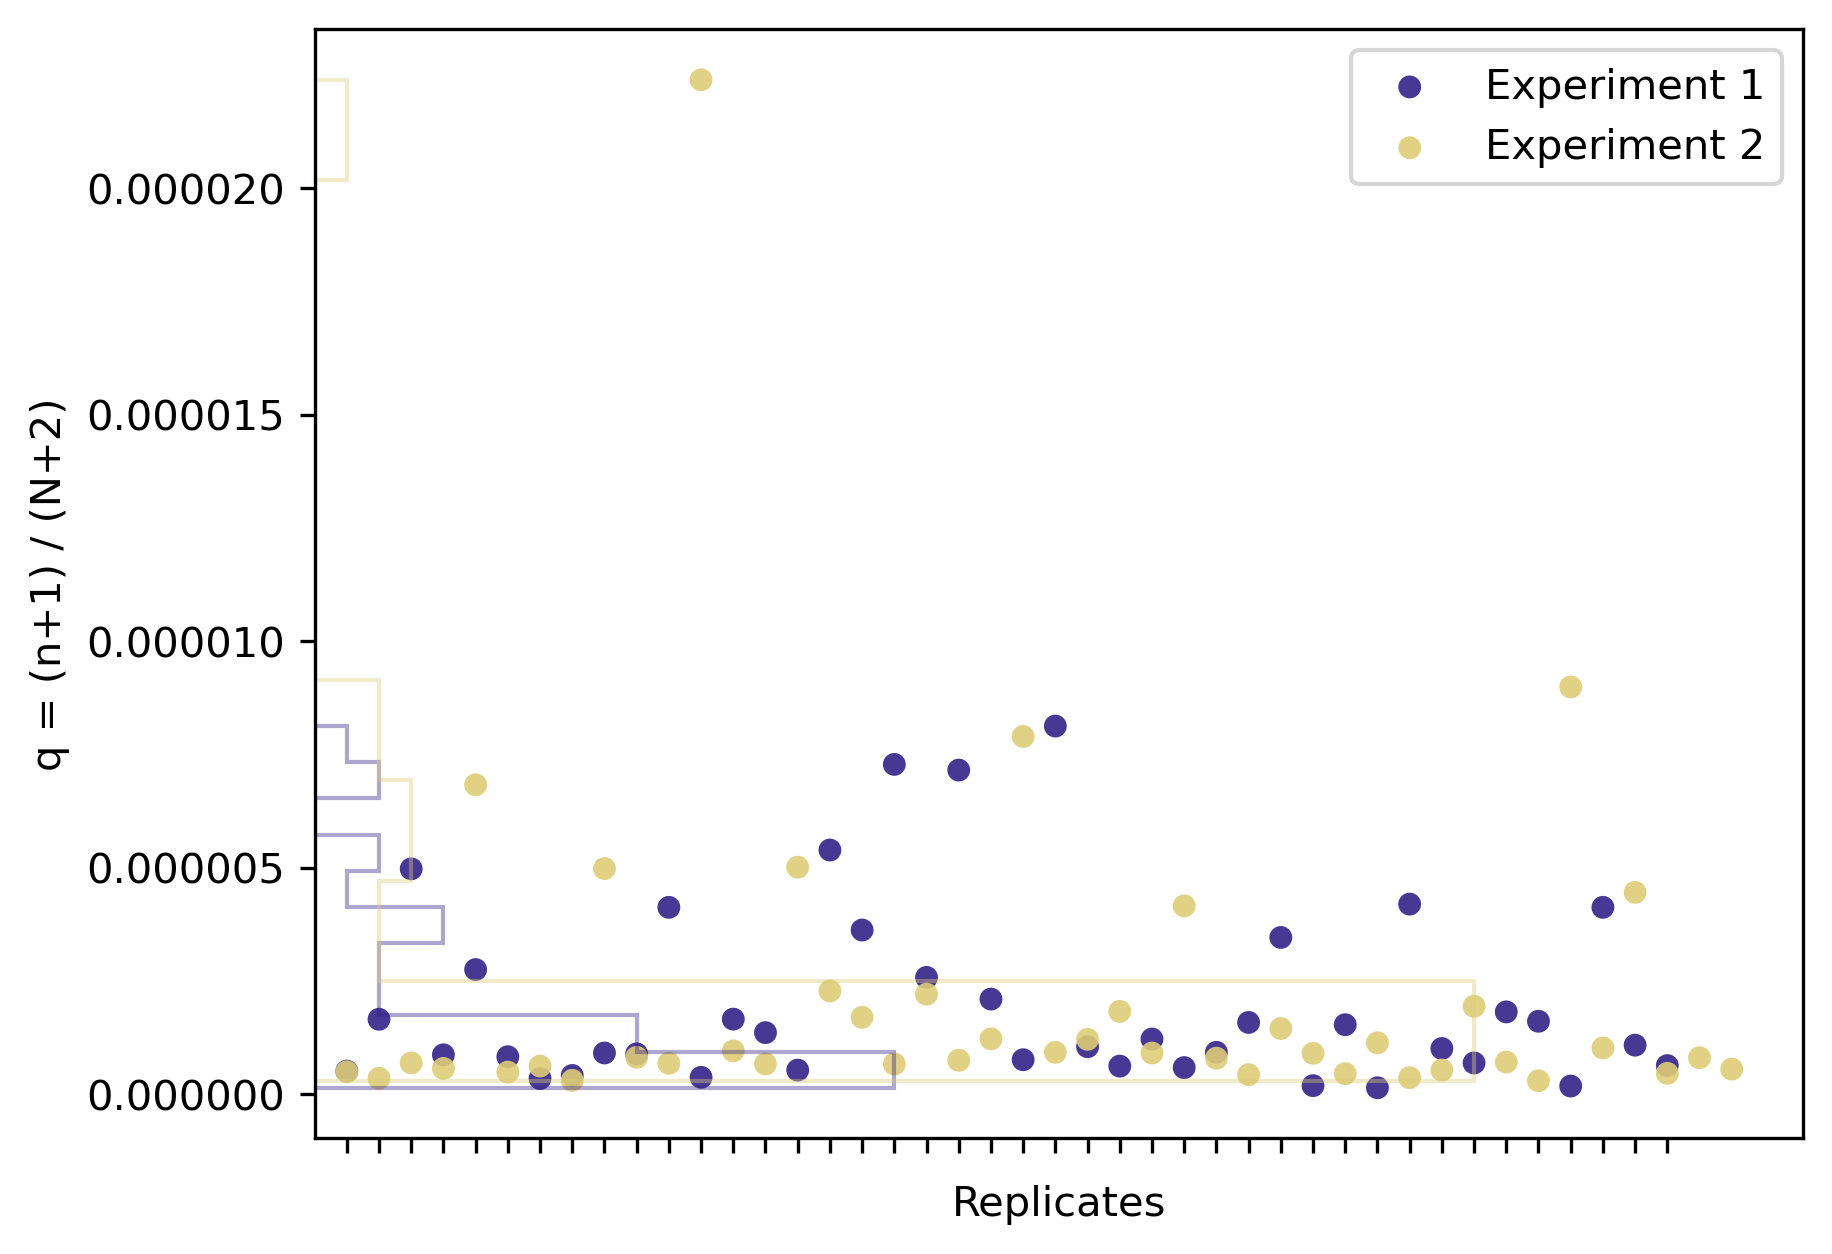

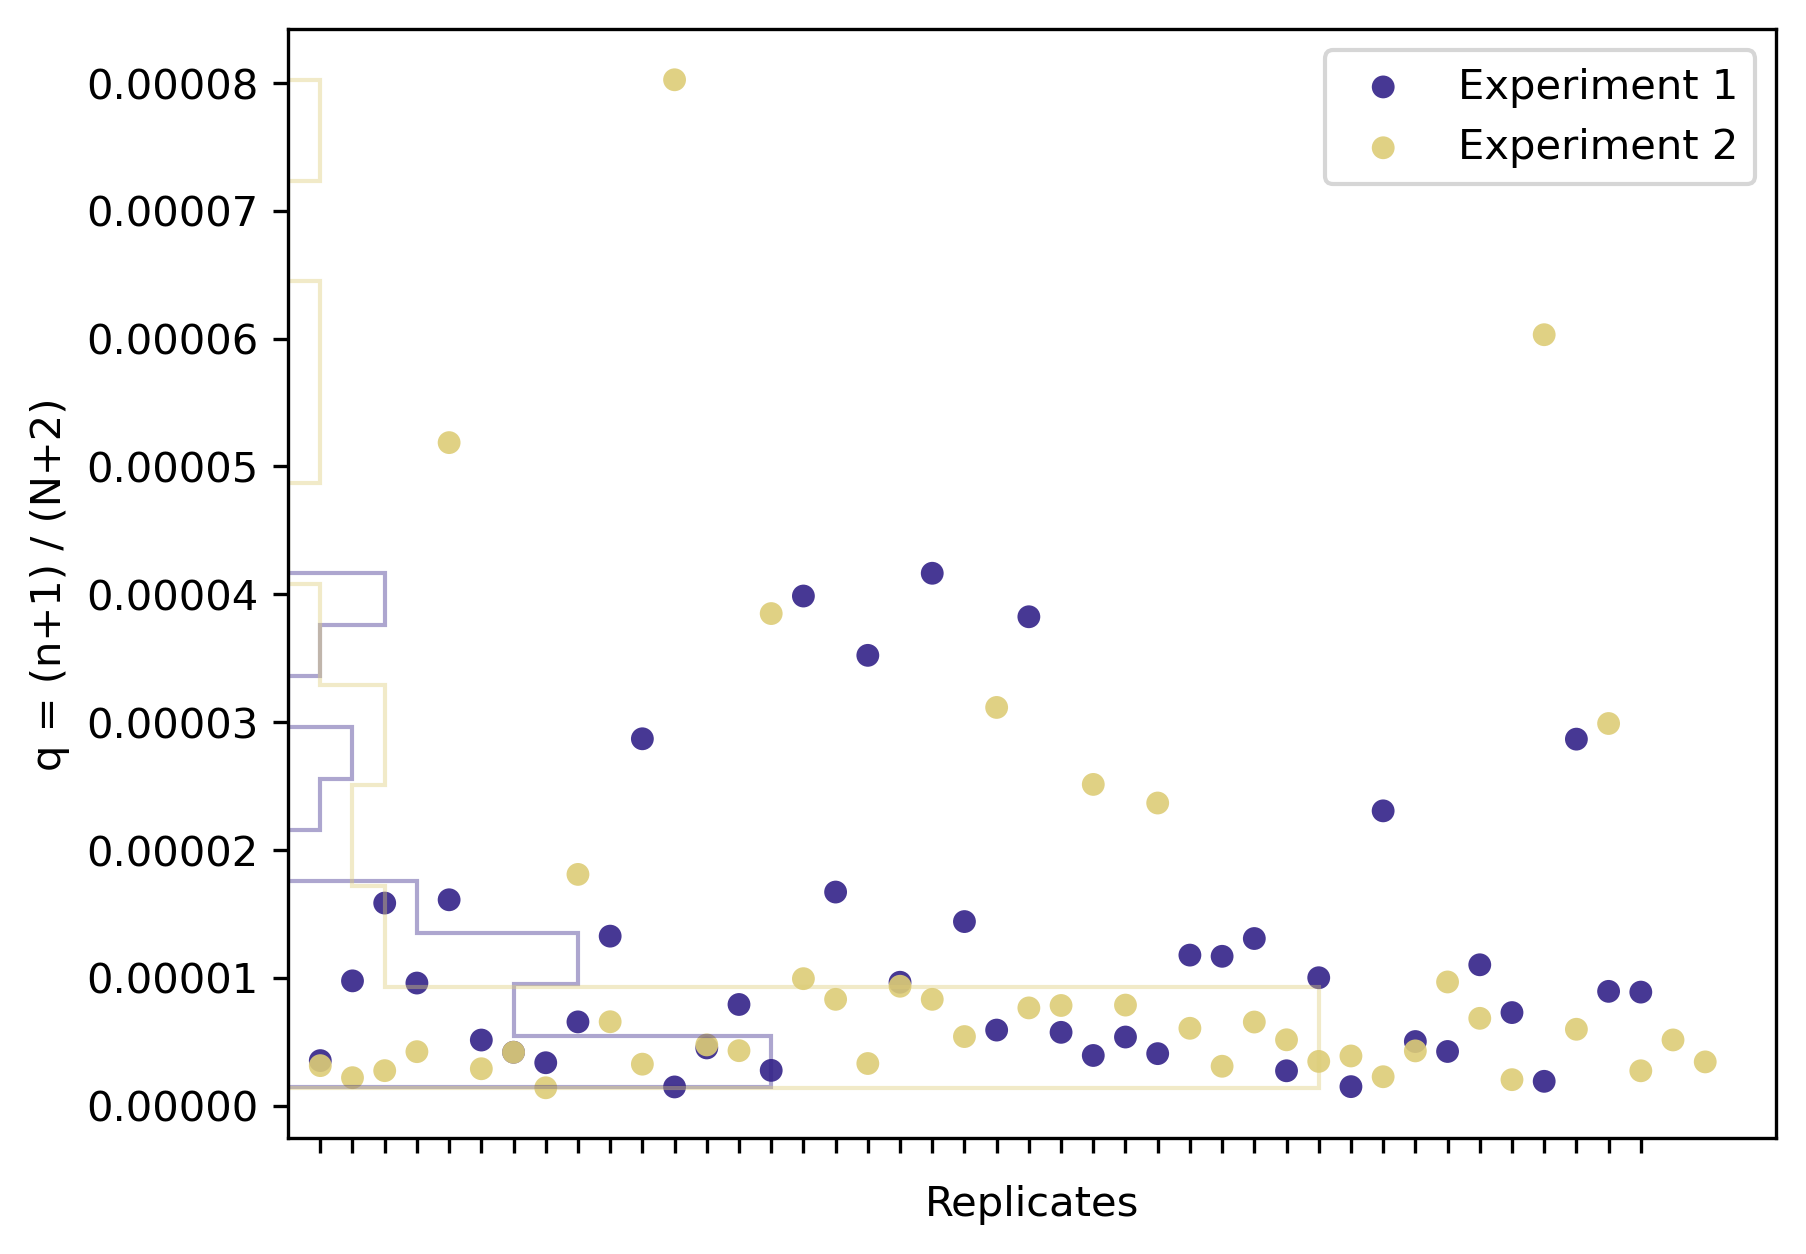

In [38]:
# plotting q values for the yeast data

q_plot(WT_yeast_q.iloc[:2,:], Snf2_yeast_q.iloc[:2,:])

# looks a lot better with so 